# TTS Models Evaluation - Zero-Shot Voice Cloning

Comprehensive evaluation of YourTTS and XTTS v2 models across multiple dimensions:
- **Performance**: RTF (Real-Time Factor), generation time
- **Quality**: PESQ (Perceptual Evaluation of Speech Quality), STOI (Short-Time Objective Intelligibility)
- **Similarity**: Speaker voice similarity using Resemblyzer embeddings

## 1. Setup and Imports

In [1]:
import json
import warnings
from pathlib import Path

import librosa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pesq import pesq
from pystoi import stoi
from resemblyzer import VoiceEncoder, preprocess_wav

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

## 2. Utility Functions

In [2]:
def load_audio(audio_path, target_sr=16000):
    """Load and resample audio to target sample rate."""
    audio, sr = librosa.load(audio_path, sr=target_sr)
    return audio, sr


def calculate_speaker_similarity(reference_path, generated_path):
    """Calculate cosine similarity between speaker embeddings using Resemblyzer."""
    try:
        encoder = VoiceEncoder()
        ref_wav = preprocess_wav(reference_path)
        gen_wav = preprocess_wav(generated_path)
        
        ref_embed = encoder.embed_utterance(ref_wav)
        gen_embed = encoder.embed_utterance(gen_wav)
        
        similarity = float(np.dot(ref_embed, gen_embed))
        return similarity
    except Exception as e:
        print(f"Error calculating similarity: {e}")
        return None


def calculate_pesq_score(reference_path, generated_path, sr=16000):
    """Calculate PESQ score (Perceptual Evaluation of Speech Quality)."""
    try:
        ref_audio, _ = load_audio(reference_path, sr)
        gen_audio, _ = load_audio(generated_path, sr)
        
        # Ensure same length
        min_len = min(len(ref_audio), len(gen_audio))
        ref_audio = ref_audio[:min_len]
        gen_audio = gen_audio[:min_len]
        
        score = pesq(sr, ref_audio, gen_audio, 'wb')
        return float(score)
    except Exception as e:
        print(f"Error calculating PESQ: {e}")
        return None


def calculate_stoi_score(reference_path, generated_path, sr=16000):
    """Calculate STOI score (Short-Time Objective Intelligibility)."""
    try:
        ref_audio, _ = load_audio(reference_path, sr)
        gen_audio, _ = load_audio(generated_path, sr)
        
        # Ensure same length
        min_len = min(len(ref_audio), len(gen_audio))
        ref_audio = ref_audio[:min_len]
        gen_audio = gen_audio[:min_len]
        
        score = stoi(ref_audio, gen_audio, sr, extended=False)
        return float(score)
    except Exception as e:
        print(f"Error calculating STOI: {e}")
        return None


def load_metrics_from_json(json_path):
    """Load performance metrics from JSON file."""
    with open(json_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    
    reference_audio = data.get('reference_audio', '')
    models_data = []
    
    for model in data.get('models', []):
        if model.get('success', False):
            models_data.append({
                'timestamp': data.get('timestamp', 'unknown'),
                'model': model['model'],
                'reference_audio': reference_audio,
                'output_path': model['output_path'],
                'audio_duration': model['audio_duration'],
                'generation_time': model['generation_time'],
                'rtf': model['rtf'],
                'success': True
            })
    
    return pd.DataFrame(models_data)


def compute_quality_metrics(row):
    """Compute all quality and similarity metrics for a single row."""
    ref_path = Path(row['reference_audio'])
    gen_path = Path(row['output_path'])
    
    # Convert Linux paths to Windows if needed
    if not ref_path.exists():
        ref_path = Path('../data/reference/audio_recording.mp3')
    if not gen_path.exists():
        gen_path = Path('../data/generated') / row['model'].lower().replace(' ', '') / gen_path.name
    
    metrics = {
        'similarity': None,
        'pesq': None,
        'stoi': None
    }
    
    if ref_path.exists() and gen_path.exists():
        metrics['similarity'] = calculate_speaker_similarity(str(ref_path), str(gen_path))
        metrics['pesq'] = calculate_pesq_score(str(ref_path), str(gen_path))
        metrics['stoi'] = calculate_stoi_score(str(ref_path), str(gen_path))
    
    return pd.Series(metrics)

## 3. Load Data and Compute Metrics

In [3]:
# Load all JSON result files
results_dir = Path('../results')
json_files = sorted(results_dir.glob('metrics_*.json'))

print(f"Found {len(json_files)} result files")

# Load and combine all results
all_results = [load_metrics_from_json(f) for f in json_files]
df = pd.concat(all_results, ignore_index=True) if all_results else pd.DataFrame()

if df.empty:
    print("No metrics found. Run: make run-all TEXT='Your test text'")
else:
    print(f"Loaded {len(df)} evaluations")
    print(f"\nComputing quality and similarity metrics...")
    
    # Compute quality metrics for each row
    quality_metrics = df.apply(compute_quality_metrics, axis=1)
    df = pd.concat([df, quality_metrics], axis=1)
    
    # Display summary
    print(f"\nMetrics computed successfully\n")
    display(df[['model', 'rtf', 'similarity', 'pesq', 'stoi']].head(8))

Found 4 result files
Loaded 8 evaluations

Computing quality and similarity metrics...
Loaded the voice encoder model on cpu in 0.09 seconds.
Loaded the voice encoder model on cpu in 0.01 seconds.
Loaded the voice encoder model on cpu in 0.01 seconds.
Loaded the voice encoder model on cpu in 0.01 seconds.
Loaded the voice encoder model on cpu in 0.02 seconds.
Loaded the voice encoder model on cpu in 0.02 seconds.
Loaded the voice encoder model on cpu in 0.01 seconds.
Loaded the voice encoder model on cpu in 0.01 seconds.

Metrics computed successfully



,model,rtf,similarity,pesq,stoi
0,YourTTS,0.451958,0.745356,1.117594,0.031760
1,XTTS v2,4.799025,0.777629,1.041437,0.107060
2,YourTTS,0.455721,0.750012,1.077047,0.074490
3,XTTS v2,4.963646,0.754318,1.464783,0.112291
4,YourTTS,0.556052,0.745675,1.058292,0.110411
5,XTTS v2,4.968422,0.748519,1.061200,0.101660
6,YourTTS,0.610817,0.726170,1.044012,0.108683
7,XTTS v2,5.470129,0.790494,1.119688,0.065658


### Data Overview

This table shows all computed metrics for each generated audio sample:
- **RTF**: Lower values indicate faster generation (< 1 is faster than real-time)
- **Similarity**: How closely the generated voice matches the reference speaker (0-1, higher is better)
- **PESQ**: Perceptual audio quality (1-4.5, higher is better, >3.0 is good)
- **STOI**: Speech intelligibility (0-1, higher is better, >0.7 is intelligible)

## 4. Statistical Summary

In [4]:
if not df.empty:
    summary = df.groupby('model').agg({
        'rtf': ['mean', 'std'],
        'generation_time': ['mean', 'std'],
        'similarity': ['mean', 'std'],
        'pesq': ['mean', 'std'],
        'stoi': ['mean', 'std']
    }).round(3)
    
    print("="*70)
    print("SUMMARY STATISTICS BY MODEL")
    print("="*70)
    display(summary)

SUMMARY STATISTICS BY MODEL


rtf        generation_time         similarity          pesq         \
          mean    std            mean     std       mean    std   mean    std   
model                                                                           
XTTS v2  5.050  0.291         128.033  22.725      0.768  0.020  1.172  0.198   
YourTTS  0.519  0.078          10.504   0.738      0.742  0.011  1.074  0.032   

          stoi         
          mean    std  
model                  
XTTS v2  0.097  0.021  
YourTTS  0.081  0.037

### Statistical Analysis

**Key points to look for:**
- **Mean values**: Compare average performance across models
- **Standard deviation (std)**: Lower std indicates more consistent/predictable behavior
- **Generation time**: Absolute time taken to generate audio (in seconds)

A good model should have:
- Low RTF mean (fast generation)
- High similarity, PESQ, and STOI means (good quality)
- Low standard deviations (consistent performance)

## 5. Performance Metrics Visualization

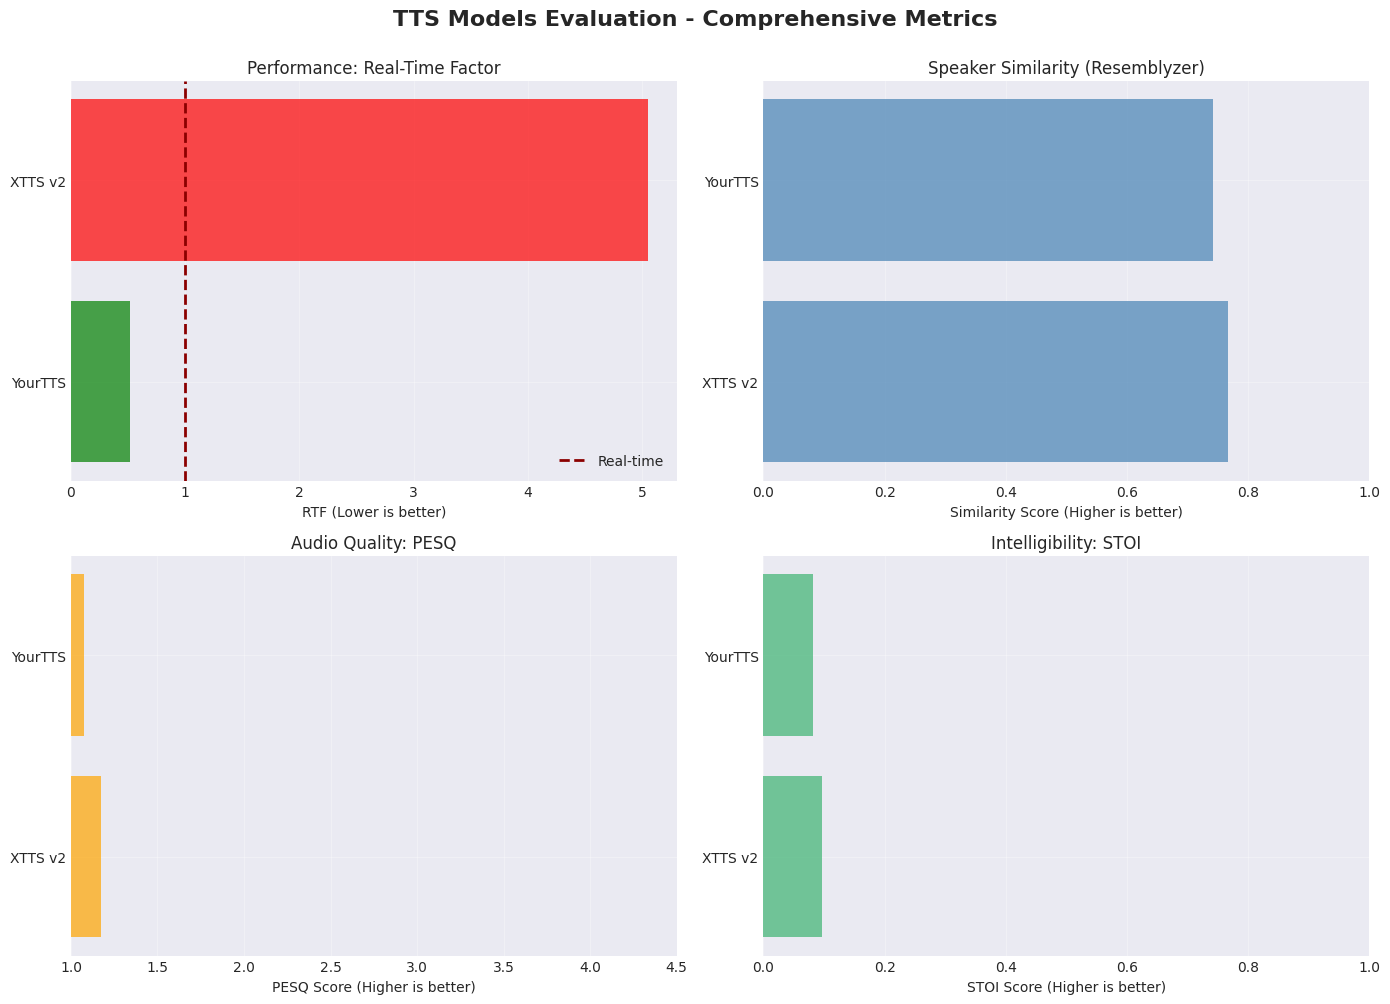

In [5]:
if not df.empty:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle('TTS Models Evaluation - Comprehensive Metrics', fontsize=16, fontweight='bold', y=1.00)
    
    # 1. RTF (Performance)
    rtf_means = df.groupby('model')['rtf'].mean().sort_values()
    colors_rtf = ['green' if x < 1 else 'red' for x in rtf_means]
    axes[0, 0].barh(rtf_means.index, rtf_means.values, color=colors_rtf, alpha=0.7)
    axes[0, 0].axvline(x=1, color='darkred', linestyle='--', linewidth=2, label='Real-time')
    axes[0, 0].set_xlabel('RTF (Lower is better)')
    axes[0, 0].set_title('Performance: Real-Time Factor')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Speaker Similarity
    sim_means = df.groupby('model')['similarity'].mean().sort_values(ascending=False)
    axes[0, 1].barh(sim_means.index, sim_means.values, color='steelblue', alpha=0.7)
    axes[0, 1].set_xlabel('Similarity Score (Higher is better)')
    axes[0, 1].set_title('Speaker Similarity (Resemblyzer)')
    axes[0, 1].set_xlim(0, 1)
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. PESQ (Quality)
    pesq_means = df.groupby('model')['pesq'].mean().sort_values(ascending=False)
    axes[1, 0].barh(pesq_means.index, pesq_means.values, color='orange', alpha=0.7)
    axes[1, 0].set_xlabel('PESQ Score (Higher is better)')
    axes[1, 0].set_title('Audio Quality: PESQ')
    axes[1, 0].set_xlim(1, 4.5)
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. STOI (Intelligibility)
    stoi_means = df.groupby('model')['stoi'].mean().sort_values(ascending=False)
    axes[1, 1].barh(stoi_means.index, stoi_means.values, color='mediumseagreen', alpha=0.7)
    axes[1, 1].set_xlabel('STOI Score (Higher is better)')
    axes[1, 1].set_title('Intelligibility: STOI')
    axes[1, 1].set_xlim(0, 1)
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

### Interpretation Guide

**Top-Left (RTF - Speed):**
- **Green bars**: Model generates audio faster than real-time (good for real-time apps)
- **Red bars**: Model is slower than real-time (needs pre-processing)
- **Dashed line**: Real-time threshold (RTF = 1)

**Top-Right (Speaker Similarity):**
- Measures how well the model clones the reference voice
- **>0.80**: Excellent voice cloning
- **0.70-0.80**: Good similarity
- **<0.70**: Noticeable difference from reference

**Bottom-Left (PESQ - Audio Quality):**
- Evaluates perceptual audio quality
- **>3.5**: Excellent quality
- **3.0-3.5**: Good quality
- **<3.0**: Acceptable quality

**Bottom-Right (STOI - Intelligibility):**
- Measures how understandable the speech is
- **>0.85**: Excellent intelligibility
- **0.75-0.85**: Good intelligibility
- **<0.75**: May have clarity issues

## 6. Multi-Metric Radar Chart

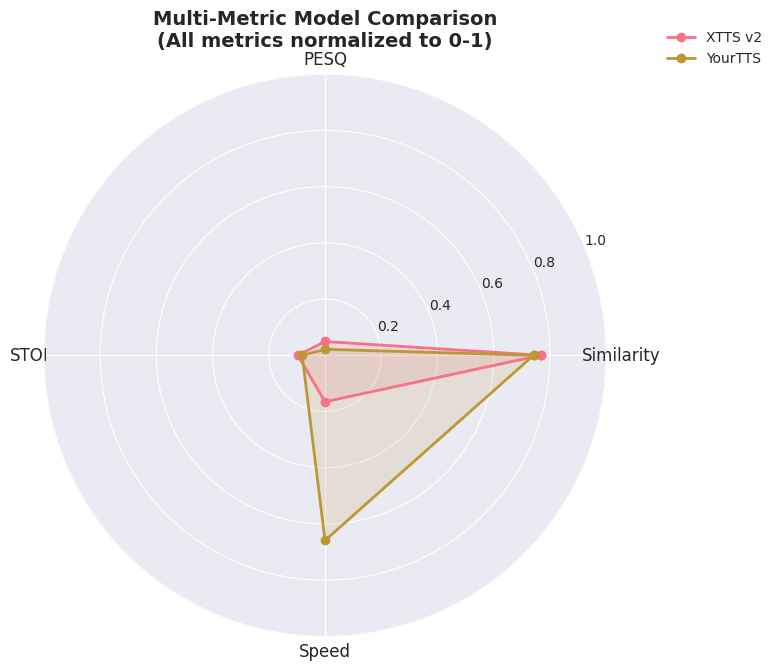

In [6]:
if not df.empty:
    # Prepare normalized data for radar chart
    metrics_agg = df.groupby('model').agg({
        'similarity': 'mean',
        'pesq': 'mean',
        'stoi': 'mean',
        'rtf': 'mean'
    })
    
    # Normalize metrics to 0-1 scale (RTF inverted: lower is better)
    metrics_agg['rtf_normalized'] = 1 / (1 + metrics_agg['rtf'])  # Inverse for "lower is better"
    metrics_agg['pesq_normalized'] = (metrics_agg['pesq'] - 1) / 3.5  # PESQ range: 1-4.5
    metrics_agg['similarity_normalized'] = metrics_agg['similarity']
    metrics_agg['stoi_normalized'] = metrics_agg['stoi']
    
    # Radar chart setup
    categories = ['Similarity', 'PESQ', 'STOI', 'Speed']
    N = len(categories)
    angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
    angles += angles[:1]
    
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(projection='polar'))
    
    for model in metrics_agg.index:
        values = [
            metrics_agg.loc[model, 'similarity_normalized'],
            metrics_agg.loc[model, 'pesq_normalized'],
            metrics_agg.loc[model, 'stoi_normalized'],
            metrics_agg.loc[model, 'rtf_normalized']
        ]
        values += values[:1]
        ax.plot(angles, values, 'o-', linewidth=2, label=model)
        ax.fill(angles, values, alpha=0.15)
    
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, size=12)
    ax.set_ylim(0, 1)
    ax.set_title('Multi-Metric Model Comparison\n(All metrics normalized to 0-1)', 
                 size=14, fontweight='bold', pad=20)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    ax.grid(True)
    
    plt.tight_layout()
    plt.show()

### Radar Chart Analysis

This chart provides a holistic view of model performance across all dimensions:

**How to read:**
- All metrics are normalized to 0-1 scale (outer edge = best)
- **Larger area** = Better overall performance
- **Balanced shape** = Consistent performance across metrics
- **Spiky shape** = Model excels in some areas but lacks in others

**What to look for:**
- A model with a large, balanced polygon is ideal for general use
- A model strong in Similarity but weak in Speed might be better for offline voice cloning
- A model strong in Speed might be better for real-time applications, even with slightly lower quality

## 7. Overall Evaluation Results

In [7]:
if not df.empty:
    # Calculate winners for each metric
    model_means = df.groupby('model').agg({
        'rtf': 'mean',
        'similarity': 'mean',
        'pesq': 'mean',
        'stoi': 'mean'
    })
    
    fastest_model = model_means['rtf'].idxmin()
    best_similarity = model_means['similarity'].idxmax()
    best_pesq = model_means['pesq'].idxmax()
    best_stoi = model_means['stoi'].idxmax()
    
    print("="*70)
    print("EVALUATION RESULTS")
    print("="*70)
    print(f"\nFastest (lowest RTF): {fastest_model}")
    print(f"   RTF: {model_means.loc[fastest_model, 'rtf']:.2f}x")
    
    print(f"\nBest Speaker Similarity: {best_similarity}")
    print(f"   Similarity: {model_means.loc[best_similarity, 'similarity']:.3f}")
    
    print(f"\nBest Audio Quality (PESQ): {best_pesq}")
    print(f"   PESQ: {model_means.loc[best_pesq, 'pesq']:.2f}")
    
    print(f"\nBest Intelligibility (STOI): {best_stoi}")
    print(f"   STOI: {model_means.loc[best_stoi, 'stoi']:.3f}")
    print("="*70)

EVALUATION RESULTS

Fastest (lowest RTF): YourTTS
   RTF: 0.52x

Best Speaker Similarity: XTTS v2
   Similarity: 0.768

Best Audio Quality (PESQ): XTTS v2
   PESQ: 1.17

Best Intelligibility (STOI): XTTS v2
   STOI: 0.097


### Final Recommendations

**Use Case Selection:**

| Use Case | Priority Metrics | Recommended Model |
|----------|------------------|-------------------|
| **Real-time voice assistants** | RTF < 1 | Model with lowest RTF |
| **High-quality audiobooks** | PESQ, STOI | Model with best quality scores |
| **Voice cloning/mimicking** | Similarity | Model with highest similarity |
| **Live dubbing** | RTF + Similarity | Balanced performance |
| **Content creation** | PESQ + STOI + Similarity | Best overall quality |

**Trade-offs to consider:**
- Speed vs Quality: Faster models may sacrifice some audio quality
- Similarity vs Intelligibility: Perfect voice matching might reduce clarity
- Consistency: Check std values - predictable performance matters for production

## 8. Export Results

In [8]:
if not df.empty:
    # Export detailed results
    output_csv = results_dir / 'evaluation_complete.csv'
    df.to_csv(output_csv, index=False)
    print(f"Detailed results: {output_csv}")
    
    # Export summary statistics
    summary_stats = df.groupby('model').agg({
        'rtf': ['mean', 'std', 'min', 'max'],
        'similarity': ['mean', 'std', 'min', 'max'],
        'pesq': ['mean', 'std', 'min', 'max'],
        'stoi': ['mean', 'std', 'min', 'max']
    }).round(3)
    
    output_stats = results_dir / 'evaluation_summary.csv'
    summary_stats.to_csv(output_stats)
    print(f"Summary statistics: {output_stats}")

Detailed results: ../results/evaluation_complete.csv
Summary statistics: ../results/evaluation_summary.csv
